In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import sys

sns.set(style="ticks")

sourceDir = '/home/brant/Development/benchmarking-models/'
files = [sourceDir + 'mobilenet-zed.log', sourceDir + 'mobilenet-x86.log']

In [95]:
def getAllData(files):
    """Given a list of files, get all data for each file"""
    
    avgTimes = re.compile(r'Timings \(microseconds\): .*? avg=(?P<avg>\d+)')
    numThreads = re.compile(r'Num threads: \[(?P<num>\d+?)\]')
    model = re.compile(r'Model name:\s{12}(?P<model>.+)')
    
    summaryGroup = re.compile(r"""=+\s+[Node\stype].+\n
        \s+(?P<conv2d>CONV_2D)\s+\d+\s+(?P<conv_avg>\d+\.\d+).+\n
        \s+(?P<depthwise>DEPTHWISE_CONV_2D)\s+\d+\s+(?P<depth_avg>\d+\.\d+).+\n
        \s+(?P<avg_pool>AVERAGE_POOL_2D)\s+\d+\s+(?P<pool_avg>\d+\.\d+).+\n
        \s+(?P<softmax>SOFTMAX)\s+\d+\s+(?P<softmax_avg>\d+\.\d+).+\n
        \s+(?P<reshape>RESHAPE)\s+\d+\s+(?P<reshape_avg>\d+\.\d+)\s+""", re.X)
    
    individualNodes = re.compile(r"""\s+
        (?P<node_name>\S+)\s+ 
        \d+\.\d+ \s+
        \d+\.\d+ \s+
        (?P<node_avg>\d+\.\d+)""", re.X)
    
    runOrder = re.compile(r"""=+ Run Order =+\n""")
    compTime = re.compile(r"""=+ Top by Computation Time =+\n""")
    
    threads = []
    avgTotals = []
    models = []
    threadsAndModel = []
    nodeTypes = []
    nodeTypeAvgs = []
    threadCounts = []
    
    for file in files:
        with open(file) as f:
            lines = f.read()
            
            """find all the data"""
            currThreads = re.findall(numThreads, lines)
            summary = re.findall(summaryGroup, lines)
            totals = re.findall(avgTimes, lines)
            modelName = re.search(model, lines).group('model')
            
            avgTotals.extend(totals)
            threads.extend(currThreads)
            mName = [modelName] * len(currThreads)
            models.extend(mName)
           
            """cast the avg times and threads as ints, since re returns them as strings"""
            for i in range(len(avgTotals)):
                avgTotals[i] = int(avgTotals[i])
                threads[i] = int(threads[i])
            
            """after finding matches, create list for thread counts that matches number of nodes 
            that have that number of threads"""
            print(currThreads)
            for n in currThreads:
                for x in range(int(len(summary[0]) / 2)):
                    threadCounts.append(int(n))
        
            """separate nodeTypes and avg times into 2 different lists to go into the data frame"""
            
            groupCount=0
            for group in summary:
                for i in range(len(group)):
                    if i % 2 == 0:
                        nodeTypes.append(group[i])
                        threadsAndModel.append(str(currThreads[groupCount]) + '-' + modelName)
                    else:
                        nodeTypeAvgs.append(float(group[i]))
                groupCount+=1
    
    threadData = {"# threads" : threads, "avg runtime (ms)" : avgTotals, "model" : models}
    
    nodeData = {"avg ms" : nodeTypeAvgs, "node type" : nodeTypes, "model" : threadsAndModel }
    return (pd.DataFrame(threadData), pd.DataFrame(nodeData))

getAllData(files)

['1', '2', '3', '4']
['1', '2', '4', '8', '12']


(   # threads  avg runtime (ms)                                    model
 0          1            749957              ARMv7 Processor rev 0 (v7l)
 1          2            390865              ARMv7 Processor rev 0 (v7l)
 2          3            635732              ARMv7 Processor rev 0 (v7l)
 3          4            681744              ARMv7 Processor rev 0 (v7l)
 4          1            458610  Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
 5          2            235533  Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
 6          4            121331  Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
 7          8            120500  Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
 8         12             90137  Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz,
      avg ms          node type                                       model
 0   609.980            CONV_2D               1-ARMv7 Processor rev 0 (v7l)
 1   139.606  DEPTHWISE_CONV_2D               1-ARMv7 Processor rev 0 (v7l)
 2     0.270    AVERAGE_POOL_2D          

['1', '2', '3', '4']
['1', '2', '4', '8', '12']


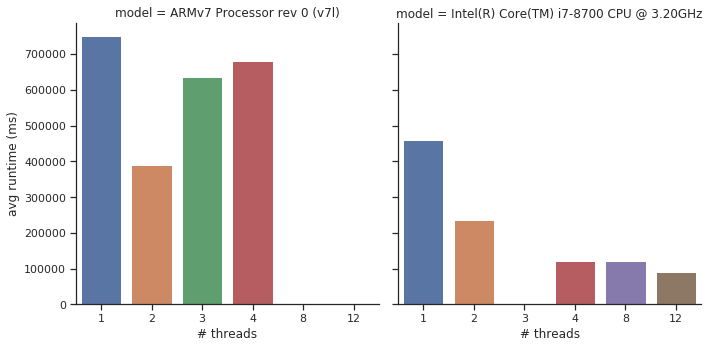

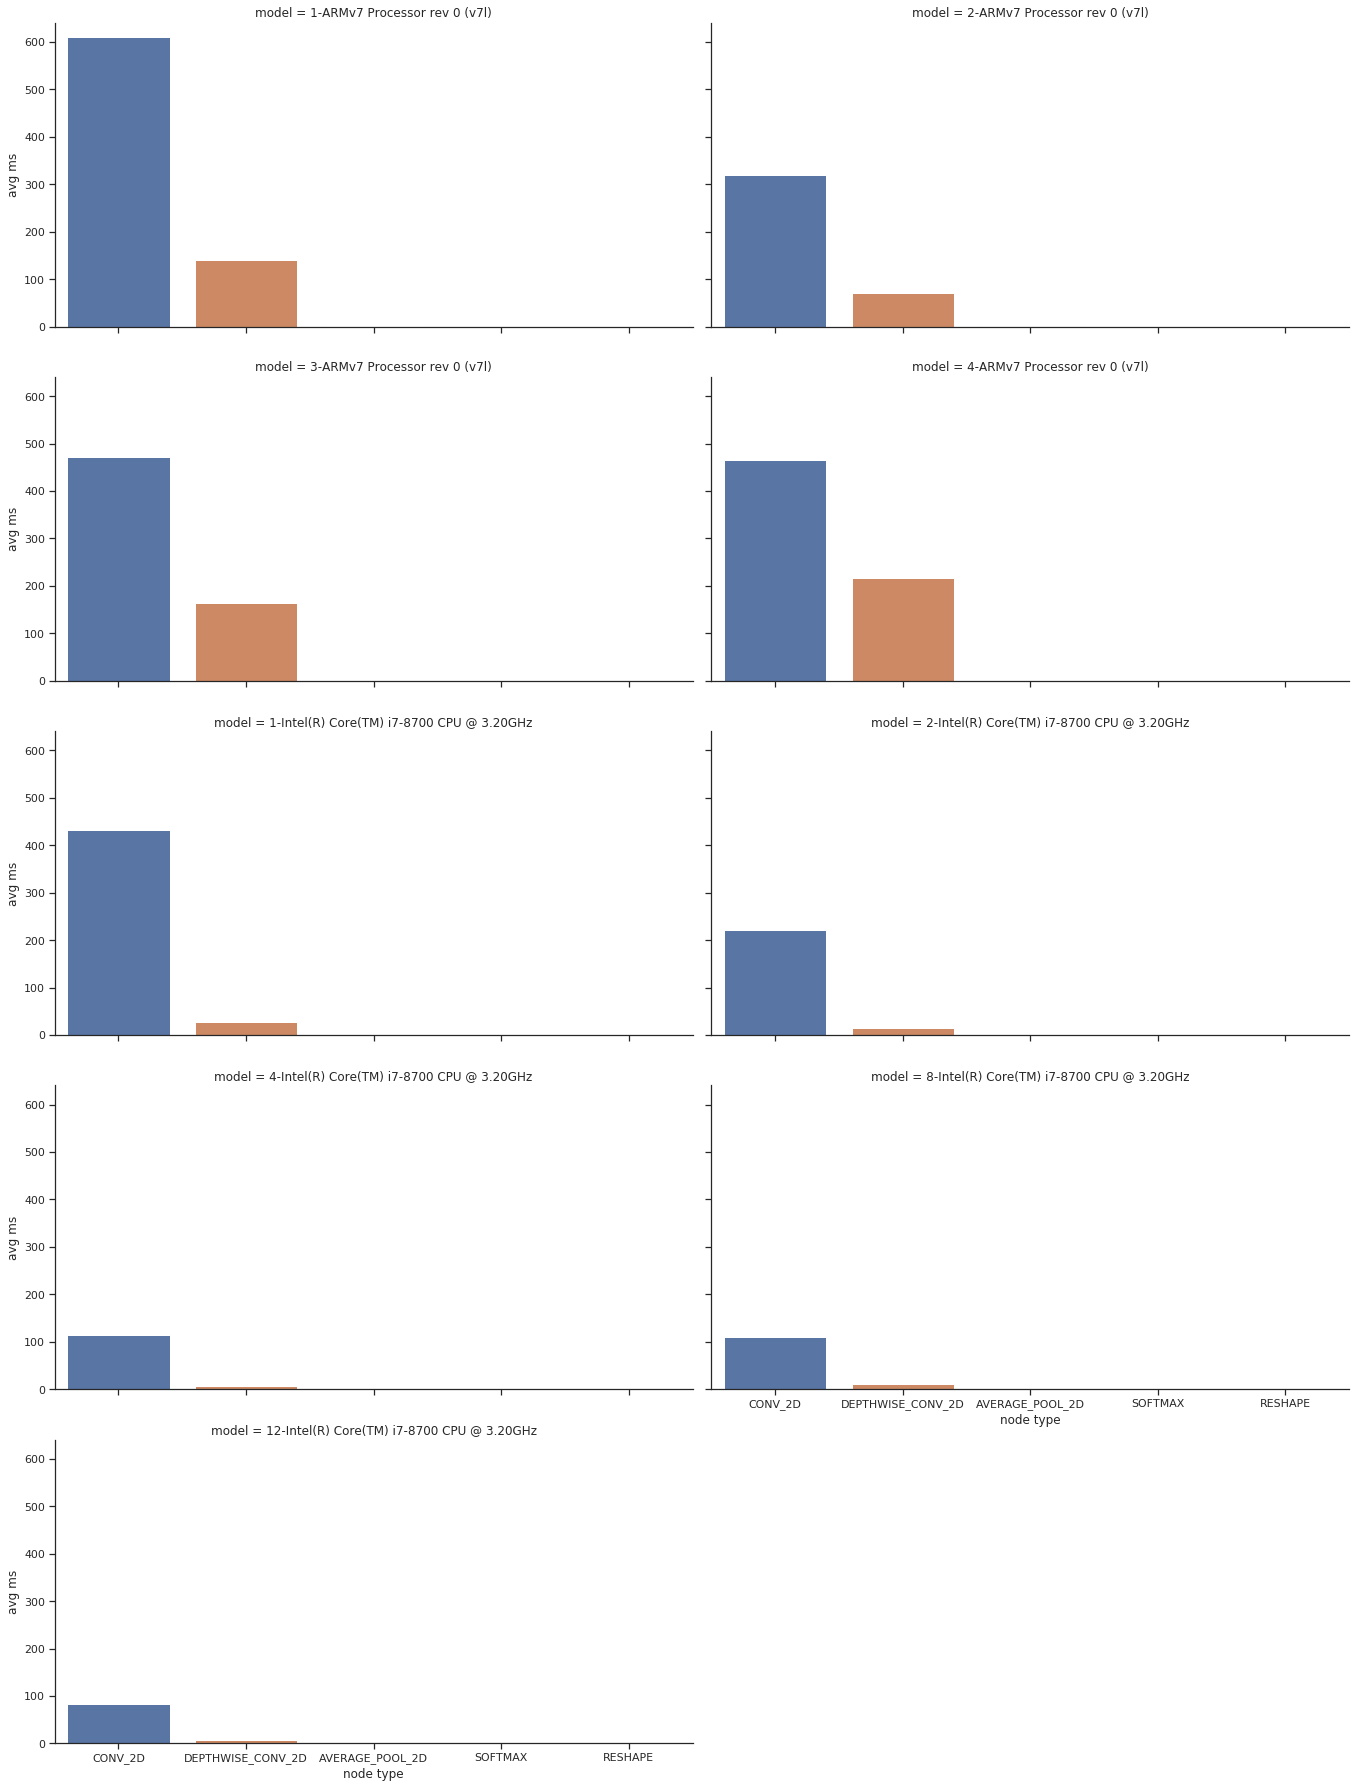

In [96]:
def plotAll(files) :
    datasets = getAllData(files)
    
    sns.catplot("# threads", col="model", y="avg runtime (ms)", kind="bar", data=datasets[0])
    
    sns.catplot("node type", y="avg ms", kind="bar", col = "model", data=datasets[1], 
                col_wrap=2, ci=None, aspect = 1.9)

plotAll(files)

In [34]:
def getIndividualNodeData(file): 
    individualNodes = re.compile(r"""\s+
        (?P<node_name>\S+)\s+ 
        \d+\.\d+ \s+
        \d+\.\d+ \s+
        (?P<node_avg>\d+\.\d+)""", re.X)
    
    runOrder = re.compile(r"""=+ Run Order =+\n""")
    compTime = re.compile(r"""=+ Top by Computation Time =+\n""")
    
    with open(file) as f:
        lines = f.read()
        
        runLocations = re.finditer(runOrder, lines)
        
        compTimeLocations = re.finditer(compTime, lines)
        
        nodes = []
        runtimes = []
        for run in runLocations:
            end = next(compTimeLocations).start()
            
            runData = re.findall(individualNodes, lines[run.start():end])
            
            for node in runData:
                nodes.append(node[0])
            
                runtimes.append(float(node[1]))
        data = {"node" : nodes, "avg ms" : runtimes}
        return pd.DataFrame(data)
    
    
getIndividualNodeData(files[0])
    
    

,node,avg ms
0,CONV_2D,40.868
1,DEPTHWISE_CONV_2D,31.060
2,CONV_2D,72.266
3,DEPTHWISE_CONV_2D,16.286
4,CONV_2D,43.774
...,...,...
119,CONV_2D,33.987
120,AVERAGE_POOL_2D,0.261
121,CONV_2D,12.312
122,RESHAPE,0.007


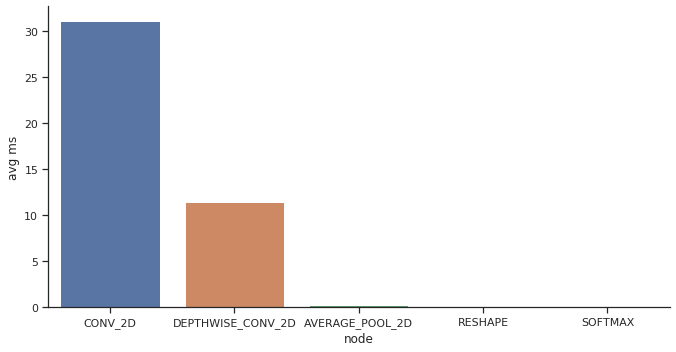

In [35]:
def plotIndividualNodes(file):
    nodeData = getIndividualNodeData(file)
    
    sns.catplot(x="node", y="avg ms", kind="bar",data=nodeData, ci=None, aspect = 1.9)


plotIndividualNodes(files[0])

In [86]:
"""Main method - to be called from command line"""

if __name__ == '__main__':
    '''main method for running the script'''
    results = sys.argv[1] #a list of files (folder) containing the results to be graphed
    save = sys.argv[2] #boolean representing whether or not to save the graphs
     
    plotAll(results)
    

"\nif __name__ == '__main__':\n    '''main method for running the script'''\n    results = sys.argv[1] #a list of files (folder) containing the results to be graphed\n    save = sys.argv[2] #boolean representing whether or not to save the graphs\n     \n    getThreadDataFromFiles(results)\n    getNodeDataFromFiles(results)\n    "

The following code are older versions of the above

In [57]:
def getThreadDataFromFiles(files):
    """creates regular expressions to find the different quantities of threads used and their associated
    runtimes for the models in the given list of files, returns a DataFrame"""
    
    threads = []
    avgs = []
    models = []
    
    for file in files:
        avgTimes = re.compile(r'Timings \(microseconds\): .*? avg=(?P<avg>\d+)')
        numThreads = re.compile(r'Num threads: \[(?P<num>\d+?)\]')
        model = re.compile(r'Model name:\s{12}(?P<model>.+)')
        
        with open(file) as f:
            lines = f.read()
            
            """finds the numbers of threads used on this model"""
            currThreads = re.findall(numThreads, lines)
            
            """adds the current data to the collection of data for all files"""
            threads.extend(currThreads)
            avgs.extend(re.findall(avgTimes, lines))
            modelName = re.search(model, lines).group('model')
            
            mName = [modelName] * len(currThreads)
            models.extend(mName)
           
            """cast the avg times and threads as ints, since re returns them as strings"""
            for i in range(len(avgs)):
                avgs[i] = int(avgs[i])
                threads[i] = int(threads[i])
    print(avgs)
    data = {"avg runtime(microseconds)": avgs, "# threads": threads, "model": models}
    
    return pd.DataFrame(data)



[749957, 390865, 635732, 681744]


,avg runtime(microseconds),# threads,model
0,749957,1,ARMv7 Processor rev 0 (v7l)
1,390865,2,ARMv7 Processor rev 0 (v7l)
2,635732,3,ARMv7 Processor rev 0 (v7l)
3,681744,4,ARMv7 Processor rev 0 (v7l)


[749957, 390865, 635732, 681744, 458610, 235533, 121331, 120500, 90137]


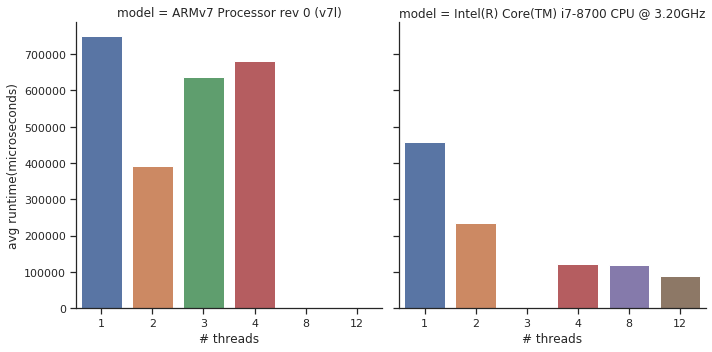

In [4]:
def plotThreadsFromFiles(files):
    """Plot the data from the given list file names in a bar chart"""
    dataSets = getThreadDataFromFiles(files)
    
    sns.catplot("# threads", col="model", y="avg runtime(microseconds)", kind="bar", data=dataSets)
        


plotThreadsFromFiles(files)

In [5]:
def getNodeData(file):
    """searches the given file for node data, returns a DataFrame"""
    
    summaryGroup = re.compile(r"""=+\s+[Node\stype].+\n
        \s+(?P<conv2d>CONV_2D)\s+\d+\s+(?P<conv_avg>\d+\.\d+).+\n
        \s+(?P<depthwise>DEPTHWISE_CONV_2D)\s+\d+\s+(?P<depth_avg>\d+\.\d+).+\n
        \s+(?P<avg_pool>AVERAGE_POOL_2D)\s+\d+\s+(?P<pool_avg>\d+\.\d+).+\n
        \s+(?P<softmax>SOFTMAX)\s+\d+\s+(?P<softmax_avg>\d+\.\d+).+\n
        \s+(?P<reshape>RESHAPE)\s+\d+\s+(?P<reshape_avg>\d+\.\d+)\s+""", re.X)
    
    numThreads = re.compile(r'Num threads: \[(?P<num>\d+?)\]')
    
    with open(file) as f:
        lines = f.read()
        
        summary = re.findall(summaryGroup, lines)
        threads = re.findall(numThreads, lines)
        
        """after finding matches, create list for thread counts that matches number of nodes 
        that have that number of threads"""
        threadCounts = []
        for n in threads:
            for x in range(int(len(summary[0]) / 2)):
                threadCounts.append(int(n))
        
        """separate nodeTypes and avg times into 2 different lists to go into the data frame"""
        nodeTypes = []
        avgs = []
        for group in summary:
            for i in range(len(group)):
                if i % 2 == 0:
                    nodeTypes.append(group[i])
                else:
                    avgs.append(float(group[i]))
        
        data = {"Node type" : nodeTypes, "avg ms" : avgs, "# of threads": threadCounts}
        return(pd.DataFrame(data))

getNodeData(files[0])

,Node type,avg ms,# of threads
0,CONV_2D,609.980,1
1,DEPTHWISE_CONV_2D,139.606,1
2,AVERAGE_POOL_2D,0.270,1
3,SOFTMAX,0.077,1
4,RESHAPE,0.005,1
5,CONV_2D,318.893,2
6,DEPTHWISE_CONV_2D,71.600,2
7,AVERAGE_POOL_2D,0.271,2
8,SOFTMAX,0.077,2
9,RESHAPE,0.005,2


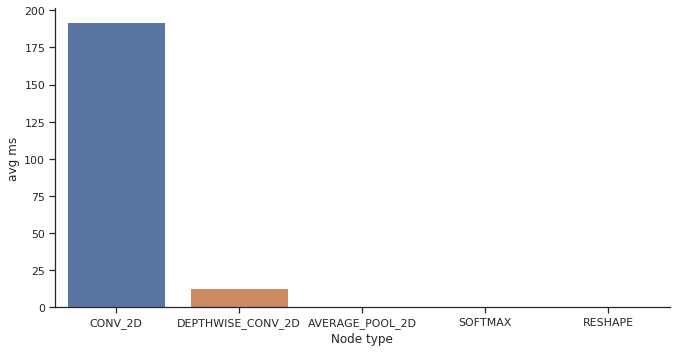

In [6]:
def plotNodes(file):
    """plot the data from the given file"""
    nodeData = getNodeData(file)
    
    sns.catplot("Node type", y="avg ms", kind="bar", data=nodeData, ci=None, aspect = 1.9)

plotNodes(files[1])

In [7]:
def getNodeDataFromFiles(files):
    """searches the given file for node data, returns a DataFrame"""
    
    summaryGroup = re.compile(r"""Summary\sby\snode\stype\s=+\s+[Node\stype].+\n
        \s+(?P<conv2d>CONV_2D)\s+\d+\s+(?P<conv_avg>\d+\.\d+).+\n
        \s+(?P<depthwise>DEPTHWISE_CONV_2D)\s+\d+\s+(?P<depth_avg>\d+\.\d+).+\n
        \s+(?P<avg_pool>AVERAGE_POOL_2D)\s+\d+\s+(?P<pool_avg>\d+\.\d+).+\n
        \s+(?P<softmax>SOFTMAX)\s+\d+\s+(?P<softmax_avg>\d+\.\d+).+\n
        \s+(?P<reshape>RESHAPE)\s+\d+\s+(?P<reshape_avg>\d+\.\d+)\s+""", re.X)
    
    numThreads = re.compile(r'Num threads: \[(?P<num>\d+?)\]')
    model = re.compile(r'Model name:\s{12}(?P<model>.+)')
    
    nodeTypes = []
    avgs = []
    threadCounts = []
    models = []
    
    for file in files:
        with open(file) as f:
            lines = f.read()
        
            summary = re.findall(summaryGroup, lines)
            threads = re.findall(numThreads, lines)
            
            
            fileThreadCounts = []
            for n in threads:
                for x in range(int(len(summary[0]) / 2)):
                    fileThreadCounts.append(int(n))
            
            fileNodeTypes = []
            fileAvgs = []
            for group in summary:
                for i in range(len(group)):
                    if i % 2 == 0:
                        fileNodeTypes.append(group[i])
                    else:
                        fileAvgs.append(float(group[i]))
            
            modelName = re.search(model, lines).group('model')
            mName = [modelName] * int(len(summary[0]) / 2) * len(summary)
            
            """after finding and gathering the local data, add it to the lists containing data for all files"""
            models.extend(mName)
            avgs.extend(fileAvgs)
            threadCounts.extend(fileThreadCounts)
            nodeTypes.extend(fileNodeTypes)
    
    threadsAndModel = []
    for i in range(len(models)):
        threadsAndModel.append(str(threadCounts[i]) + '-' + models[i])
            
    data = {"Node type" : nodeTypes, "avg ms" : avgs, "# of threads": threadCounts,\
            "model" : models, "configuration" : threadsAndModel}
    return(pd.DataFrame(data))

getNodeDataFromFiles(files)

,Node type,avg ms,# of threads,model,configuration
0,CONV_2D,609.980,1,ARMv7 Processor rev 0 (v7l),1-ARMv7 Processor rev 0 (v7l)
1,DEPTHWISE_CONV_2D,139.606,1,ARMv7 Processor rev 0 (v7l),1-ARMv7 Processor rev 0 (v7l)
2,AVERAGE_POOL_2D,0.270,1,ARMv7 Processor rev 0 (v7l),1-ARMv7 Processor rev 0 (v7l)
3,SOFTMAX,0.077,1,ARMv7 Processor rev 0 (v7l),1-ARMv7 Processor rev 0 (v7l)
4,RESHAPE,0.005,1,ARMv7 Processor rev 0 (v7l),1-ARMv7 Processor rev 0 (v7l)
5,CONV_2D,318.893,2,ARMv7 Processor rev 0 (v7l),2-ARMv7 Processor rev 0 (v7l)
6,DEPTHWISE_CONV_2D,71.600,2,ARMv7 Processor rev 0 (v7l),2-ARMv7 Processor rev 0 (v7l)
7,AVERAGE_POOL_2D,0.271,2,ARMv7 Processor rev 0 (v7l),2-ARMv7 Processor rev 0 (v7l)
8,SOFTMAX,0.077,2,ARMv7 Processor rev 0 (v7l),2-ARMv7 Processor rev 0 (v7l)
9,RESHAPE,0.005,2,ARMv7 Processor rev 0 (v7l),2-ARMv7 Processor rev 0 (v7l)


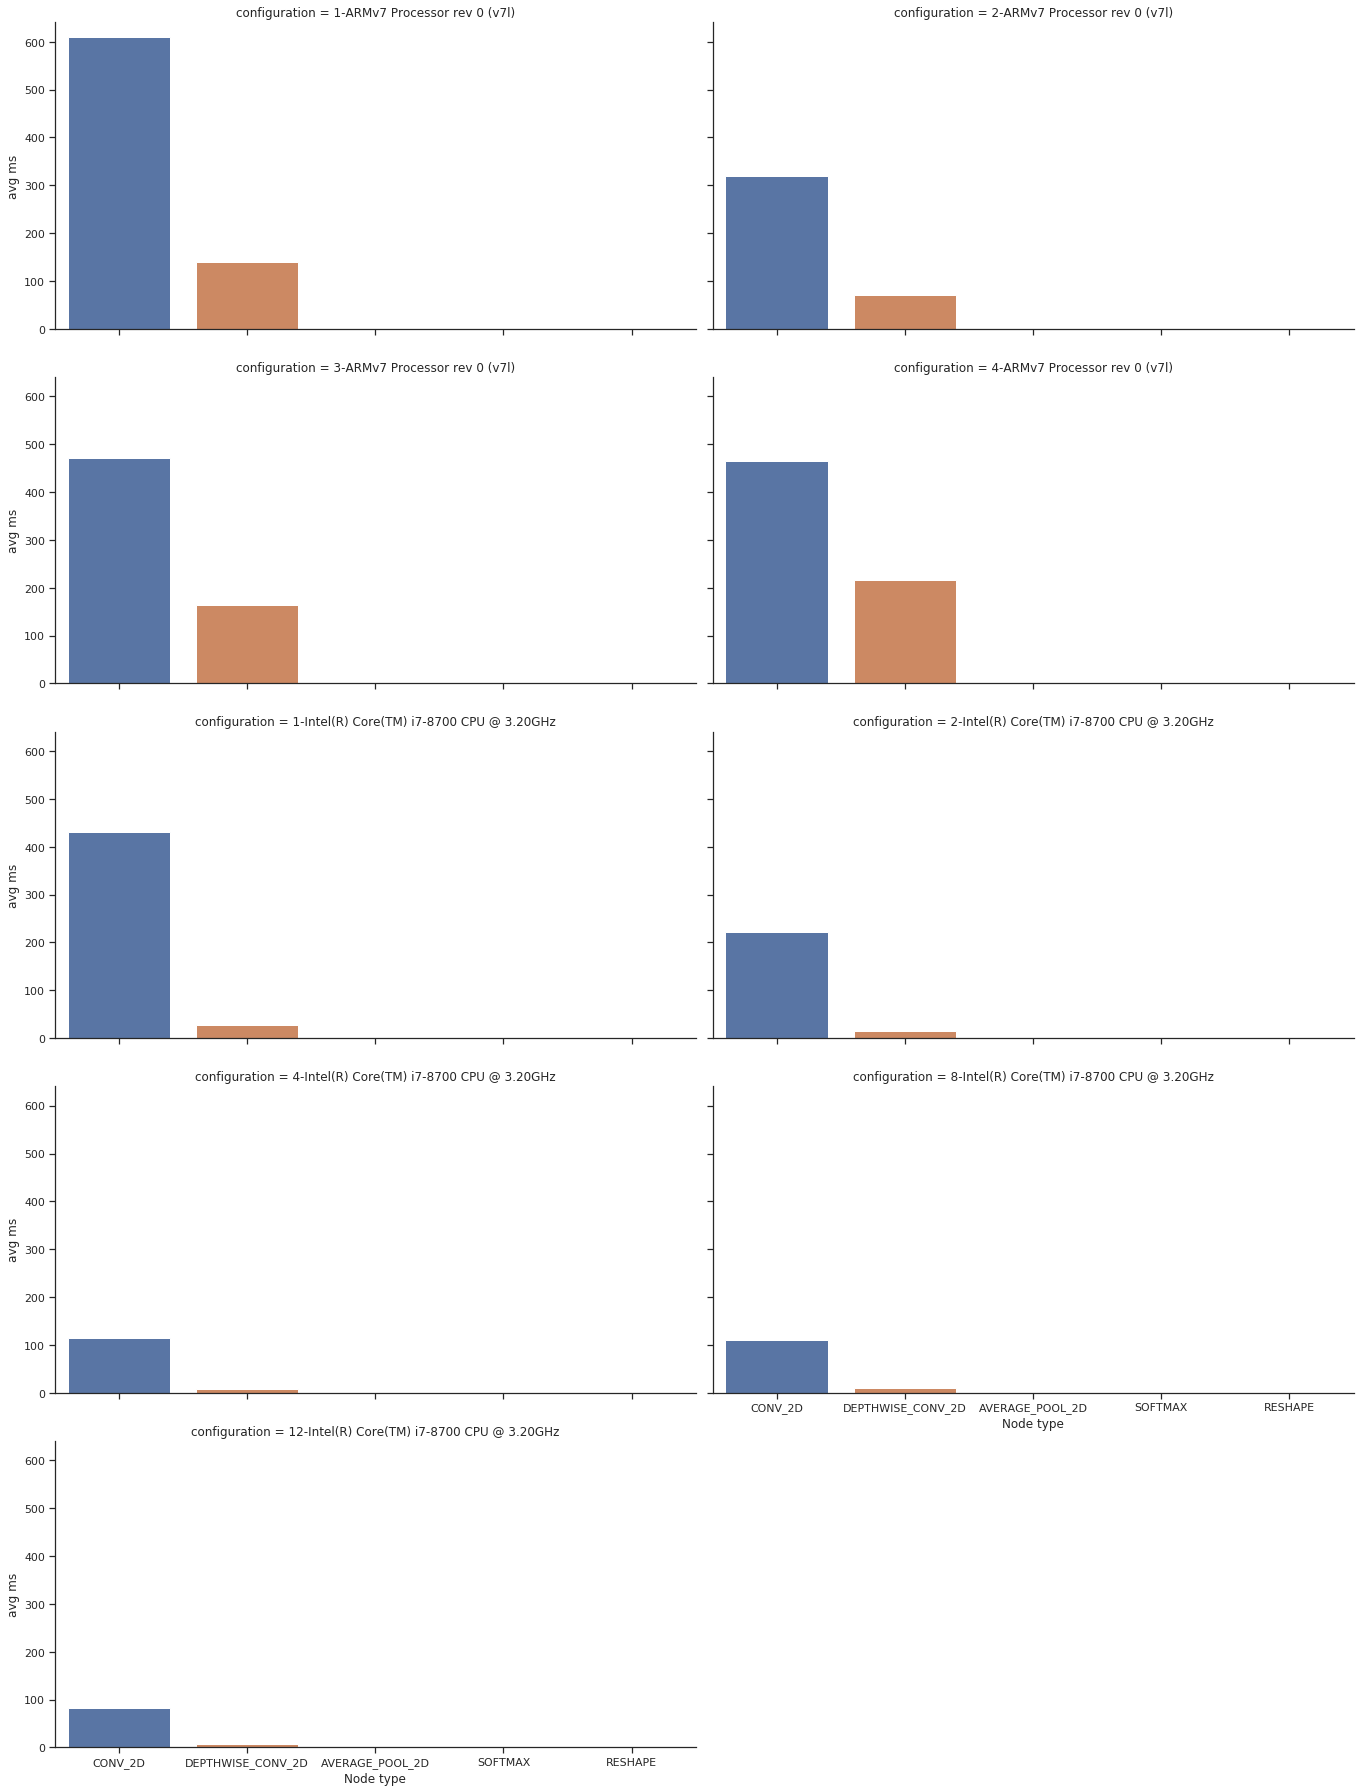

In [8]:
def plotNodesFromFiles(files):
    """plot the data from the given file"""
    nodeData = getNodeDataFromFiles(files)
    
    sns.catplot("Node type", y="avg ms", kind="bar", col = "configuration", data=nodeData, col_wrap=2, ci=None, aspect = 1.9)

plotNodesFromFiles(files)